Przed oddaniem zadania upewnij się, że wszystko działa poprawnie.
**Uruchom ponownie kernel** (z paska menu: Kernel$\rightarrow$Restart) a następnie
**wykonaj wszystkie komórki** (z paska menu: Cell$\rightarrow$Run All).

Upewnij się, że wypełniłeś wszystkie pola `TU WPISZ KOD` lub `TU WPISZ ODPOWIEDŹ`, oraz
że podałeś swoje imię i nazwisko poniżej:

In [1]:
NAME = "Piotr Szuba"

---

# 2. Uczenie nienadzorowane

W poprzednim zeszycie zbadaliśmy różne modele grafowych sieci neuronowych w scenariuszu nadzorowanej klasyfikacji wierzchołków. Teraz zajmiemy się tematem uczenia nienadzorowanego dla GNNów, który jak już wcześniej wspomnieliśmy jest trochę bardziej złożony.

W jaki sposób powinna być skonstruowana funkcja kosztu? Czy możemy zastosować model autokodera? Jak w takim razie powinien działać dekoder? Jak uwzględnić relacje między wierzchołkami?

To tylko kilka pytań, na które należy odpowiedzieć podczas opracowania nienadzorowanego modelu grafowych sieci neuronowych. W ostatnich latach powstało wiele rozwiązań, obejmujących między innymi:
- grafowe autokodery (w tym wariacyjne)
- uczenie kontrastowe
- uczenie samo-nadzorowane

W ninejszym zeszycie zbadamy **model grafowego autokodera** jako najprostszego modelu stosowanego w nienadzorowanym uczeniu reprezentacji grafów, a pozostałe obszary omówimy na najbliższym wykładzie.

## 2.1. Grafowy autokoder
W 2016 roku Kipf, autor pracy wprowadzającej architekturę GCN, opublikował również [artykuł](https://arxiv.org/pdf/1611.07308.pdf) w którym pokazał jak wykorzystać GCNa (lub dowolny inny GNNowy model) w znanej nam architekturze autokodera. Jak wiemy taki model składa się z dwóch komponentów:
- **kodera** - w tym wypadku koderem jest wybrana przez nas grafowa sieć neuronowa

$$\mathbf{Z} = \text{GNN}(\mathbf{X}, \mathbf{A})$$

- **dekodera** - model dekodera na wejściu przyjmuje wyznaczone reprezentacje $\mathbf{Z}$ a na wyjściu oblicza rekonstrukcję danego obiektu, w naszym przypadku grafu. Jednak co dokładnie powinien odtworzyć taki grafowy dekoder? Strukturę, atrybuty, czy jedno i drugie? W swojej pracy Kipf zaproponował, aby skupić się wyłącznie na strukturze grafu, tzn. dokonać rekonstrukcji krawędzi. Taki wariant również będziemy rozważać na cele tego laboratorium, przy czym inne scenariusze są równie poprawne i w zależności od konkretnego zadania mogą dostarczać lepszych wyników. 

W celu zbudowania odpowiedniego dekodera strukturalnego musimy określić w jaki sposób będziemy decydować czy istnieje krawędź między parą dowolnych wierzchołków. Najpopularniejszym rozwiązaniem jest wykorzystanie iloczynu skalarnego, podobnie jak w przypadku modelu Node2vec definiowaliśmy podobieństwo wierzchołków w przestrzeni reprezentacji. Tutaj wybór ten jest umotywowany intuicją, że podobne wierzchołki powinny być połączone krawędzią. Dekoder ma zatem postać:

$$\hat{\mathbf{A}} = \sigma(\mathbf{Z}\mathbf{Z}^T),$$

gdzie:
- $\hat{\mathbf{A}}$ to rekonstrukcja macierzy sąsiedztwa
- $\sigma(\cdot)$ to sigmoidalna funkcja aktywacji

## Zadanie 2.1. (8 pkt)
Wykorzystując zaimplementowane w PyTorch-Geometricu modele:
- grafowego autokodera `GAE` - [link](https://pytorch-geometric.readthedocs.io/en/latest/generated/torch_geometric.nn.models.GAE.html)
- dekodera iloczynu skalarnego `InnerProductDecoder` - [link](https://pytorch-geometric.readthedocs.io/en/latest/generated/torch_geometric.nn.models.InnerProductDecoder.html)

dokończ implementację klasy `UnsupervisedNodeClassificationGNN`. Zastosuj się do komentarzy umieszczonych przy odpowiednich funkcjach.

In [30]:
from typing import List, Optional, Tuple

import pytorch_lightning as pl
import torch
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from torch import nn
from torch_geometric.data import Data
from torch_geometric.nn import GAE, InnerProductDecoder

class UnsupervisedNodeClassificationGNN(pl.LightningModule):
    """Unsupervised node classification for a given GNN model."""

    def __init__(self, gnn: nn.Module):
        super().__init__()
        self._gnn = gnn
        self.gae = GAE(gnn, InnerProductDecoder())
        
        self._downstream_model = None
        self.training_step_outputs = []

    def forward(
        self,
        x: torch.Tensor,
        edge_index: torch.Tensor,
    ) -> torch.Tensor:    
        z = self.gae.encode(x, edge_index) 
        return z

    def training_step(self, batch: List[Data], batch_idx: int) -> dict:
        data = batch[0]

        z = self.forward(data.x, data.edge_index)
        loss = self.gae.recon_loss(z, data.edge_index)

        self.log("step", self.trainer.current_epoch)
        self.log("train/loss", loss.item(), on_epoch=True, on_step=False)

        return {
            "loss": loss,
            "z_train": z[data.train_mask],
            "y_train": data.y[data.train_mask],
        }
    
    def on_train_batch_end(self, outputs, batch, batch_idx) -> None:
        self.training_step_outputs.append(outputs)
    
    def on_validation_epoch_start(self) -> None:
        z_train = torch.cat([out["z_train"].detach() for out in self.training_step_outputs], dim=0)
        y_train = torch.cat([out["y_train"] for out in self.training_step_outputs], dim=0)
        self.training_step_output = []
        
        z_train = z_train.cpu().numpy()
        y_train = y_train.cpu().numpy()
        
        self._downstream_model = LogisticRegression(multi_class="ovr")
        self._downstream_model.fit(z_train, y_train)
        
        y_train_pred = self._downstream_model.predict_proba(z_train)
        auc = roc_auc_score(y_train, y_train_pred, multi_class='ovr')

        self.log("train/auc", auc, on_epoch=True, on_step=False)

    def validation_step(self, batch: List[Data], batch_idx: int):
        data = batch[0]

        auc = self._compute_auc(data=data, mask=data.val_mask)

        self.log("step", self.trainer.current_epoch)
        self.log("val/auc", auc, on_epoch=True, on_step=False)

        return {"auc": auc}

    def test_step(self, batch: List[Data], batch_idx: int):
        data = batch[0]

        auc = self._compute_auc(data=data, mask=data.test_mask)

        self.log("step", self.trainer.current_epoch)
        self.log("test/auc", auc, on_epoch=True, on_step=False)

        return {"auc": auc}

    def predict_step(
        self,
        batch: List[Data],
        batch_idx: int,
        dataloader_idx: Optional[int] = None,
    ) -> Tuple[torch.Tensor, torch.Tensor]:
        data = batch[0]

        z = self(data.x, data.edge_index)
        y = data.y

        return z, y

    def _compute_auc(self, data: Data, mask: torch.Tensor) -> float:
        z = self(data.x, data.edge_index)

        z_masked = z[mask]
        y = data.y[mask]

        if torch.is_tensor(y):
            if y.is_cuda:
                y = y.cpu()
                
        if torch.is_tensor(z_masked):
            if z_masked.is_cuda:
                z_masked = z_masked.cpu()
        
        y_pred = self._downstream_model.predict_proba(z_masked)
        auc = roc_auc_score(y, y_pred, multi_class='ovr')

        return auc

    def configure_optimizers(self):
        return torch.optim.AdamW(
            params=self.parameters(),
            lr=1e-3,
            weight_decay=5e-4,
        )

In [2]:
from src.dataset import GraphData


datamodule = GraphData(dataset_name="Cora")

Dla wszystkich modeli zdefiniujmy sobie zbiór wspólnych hiperparametrów:

In [3]:
hparams = {
    "num_epochs": 10,
    "hidden_dim":  256,
    "emb_dim": 128,
}

Porównamy teraz jakość działania modeli GNNowych, wprowadzonych w poprzednim zeszycie:

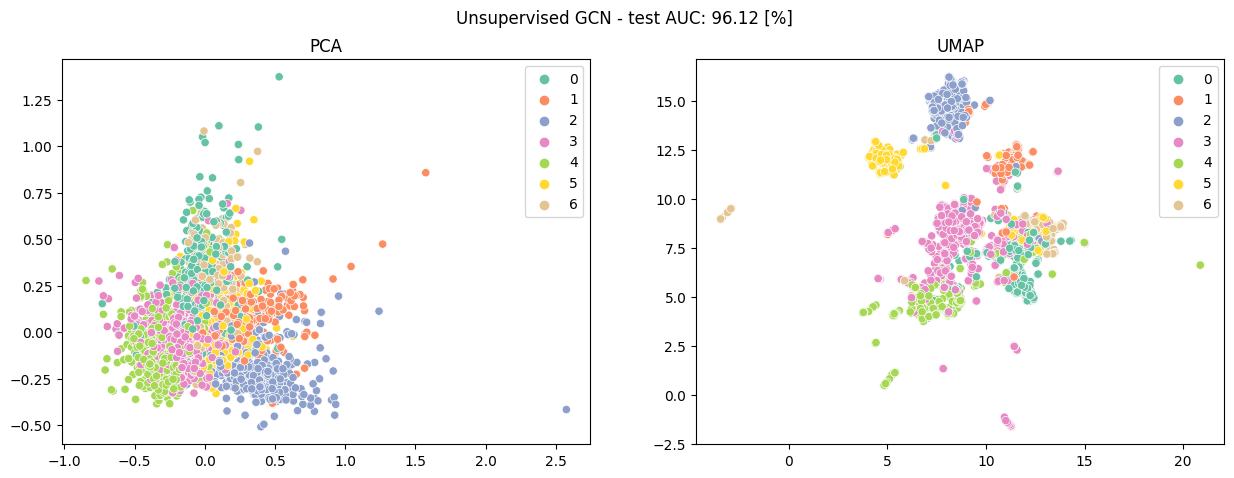

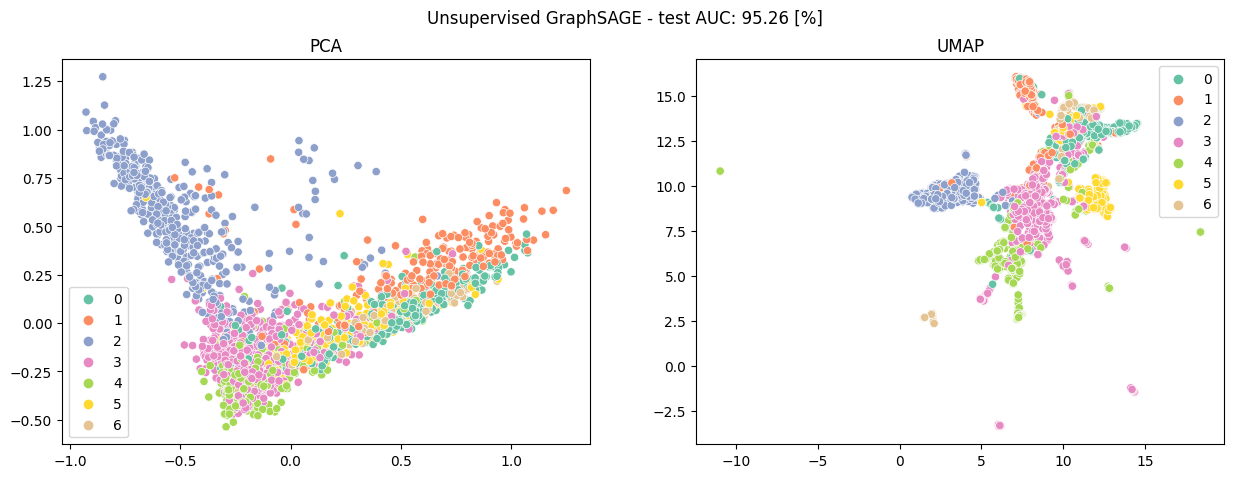

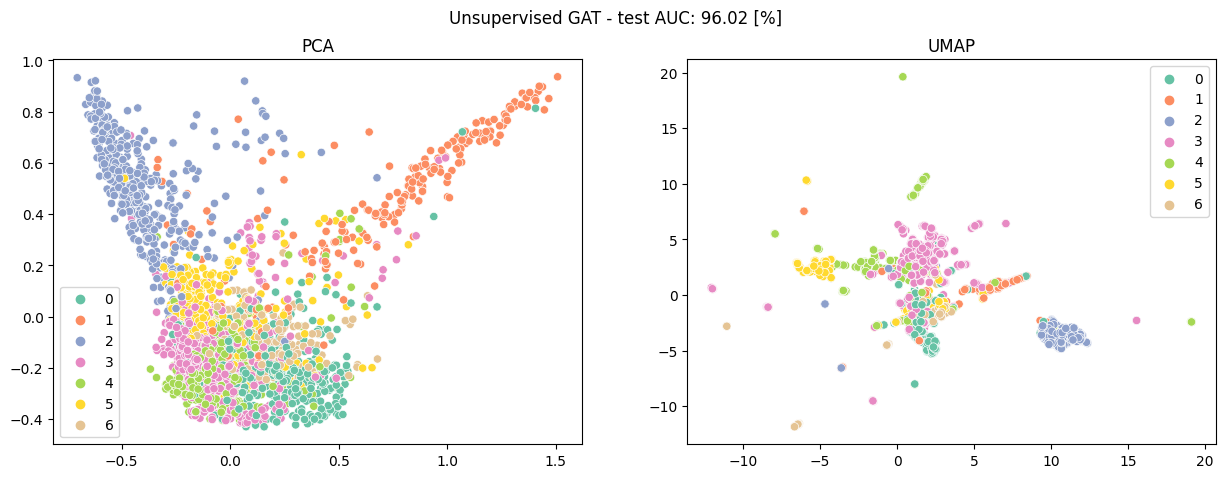

In [32]:
import matplotlib.pyplot as plt
from torch import nn
from torch_geometric.nn import GATConv
from torch_geometric.nn import GCNConv
from torch_geometric.nn import SAGEConv

from src.trainer import get_default_trainer
from src.utils import visualize_embeddings


class GCNModel(nn.Module):
    def __init__(self, in_dim: int, hidden_dim: int, out_dim: int):
        super().__init__()
        self.conv1 = GCNConv(in_dim, hidden_dim)
        self.act1 = nn.ReLU()
        self.conv2 = GCNConv(hidden_dim, out_dim)
        self.act2 = nn.ReLU()

    def forward(self, x, edge_index):
        z = self.act1(self.conv1(x, edge_index))
        z = self.act2(self.conv2(z, edge_index))
        return z


class GraphSAGEModel(nn.Module):
    def __init__(self, in_dim: int, hidden_dim: int, out_dim: int):
        super().__init__()
        self.conv1 = SAGEConv(in_dim, hidden_dim)
        self.act1 = nn.ReLU()
        self.conv2 = SAGEConv(hidden_dim, out_dim)
        self.act2 = nn.ReLU()

    def forward(self, x, edge_index):
        z = self.act1(self.conv1(x, edge_index))
        z = self.act2(self.conv2(z, edge_index))
        return z


class GATModel(nn.Module):
    def __init__(self, in_dim: int, hidden_dim: int, out_dim: int):
        super().__init__()
        self.conv1 = GATConv(in_dim, hidden_dim, heads=1)
        self.act1 = nn.ReLU()
        self.conv2 = GATConv(hidden_dim, out_dim, heads=1)
        self.act2 = nn.ReLU()

    def forward(self, x, edge_index):
        z = self.act1(self.conv1(x, edge_index))
        z = self.act2(self.conv2(z, edge_index))
        return z

    
def evaluate_unsupervised_models():
    scenarios = [
        ("GCN", GCNModel),
        ("GraphSAGE", GraphSAGEModel),
        ("GAT", GATModel),
    ]
    
    for model_name, gnn_cls in scenarios:
        gnn = gnn_cls(
            in_dim=datamodule.num_node_features,
            hidden_dim=hparams["hidden_dim"],
            out_dim=hparams["emb_dim"],
        )
    
        model=UnsupervisedNodeClassificationGNN(gnn=gnn)

        trainer = get_default_trainer(
            num_epochs=hparams["num_epochs"],
            model_name=f"unsupervised_{model_name}",
            quiet=True
        )
    
        trainer.fit(model=model, datamodule=datamodule)
    
        test_auc = trainer.test(model=model, datamodule=datamodule, verbose=False)[0]["test/auc"]
        z, y = trainer.predict(model=model, datamodule=datamodule)[0]
    
        fig = visualize_embeddings(z=z, y=y)
        fig.suptitle(f"Unsupervised {model_name} - test AUC: {test_auc * 100.:.2f} [%]")
    
        plt.show()
    

evaluate_unsupervised_models()

In [34]:
%load_ext tensorboard
%tensorboard --logdir ./data/logs/ --port 6006